In [1]:
import os
import pickle
import random
import sys

import torch
import torch.nn as nn
from torch.autograd import Variable, grad

from PIL import Image

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])

sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner
import string

In [2]:
data_folder = '/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan/differentiable_graphics_ml/data/train_v7_shapenet/' 

In [3]:
# arser = argparse.ArgumentParser()
# parser.add_argument('--dataset_name', type = str, required = True)
# parser.add_argument('--category', type = str, required = True)
# parser.add_argument('--model_files_pickle_name', type = str, required = True)
# parser.add_argument('--num_repeats', type = int, default = 400)
# args = parser.parse_args()

DATASET_NAME = 'train_v7_controlled_cluster'
CATEGORY = '02691156'
MODEL_FILES_PICKLE_NAME = 'categories_10_models_10.pkl'
# NUM_REPEATS = 2

# DATASET_NAME = args.dataset_name
# MODEL_FILES_PICKLE_NAME = args.model_files_pickle_name
# CATEGORY = args.category
# NUM_REPEATS = args.num_repeats

In [4]:
SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

def create_folder(folder_path):
    if not os.path.isdir(folder_path):
        print('Making new directory: %s'%folder_path)
        os.mkdir(folder_path)
create_folder(dataset_path)

In [5]:
def perturbation_vector(factor_len, perturb_percent):
    if factor_len == 0:
        factor_len = 1
    vec = torch.tensor([random.uniform(-perturb_percent/100,perturb_percent/100) for i in range(factor_len)])
    return vec

def perturb_param(param, perturb_percent):
    new_param = param.clone() + perturbation_vector(param.dim(), perturb_percent)
    return new_param

def random_perturbed_scene(scene, perturb_percent):
    ########## Perturb Camera ############
    camera = scene.camera
    camera_position = camera.position
    cam_look_at = camera.look_at
    fov = camera.fov
    cam_up = camera.up
    
    new_camera_position = perturb_param(camera_position, perturb_percent)
    new_cam_look_at = perturb_param(cam_look_at, perturb_percent)
    new_fov = perturb_param(fov, perturb_percent)
    new_cam_up = perturb_param(cam_up, perturb_percent)
    
    camera.position = new_camera_position
    camera.look_at = new_cam_look_at
    camera.fov = new_fov
    camera.up = new_cam_up    
    
    scene.camera = camera
    return scene

def render_shapenet_cluster(info_dict, key):
    all_light_positions, light_intensities, light_sizes, light_look_ats,\
                   camera_position, cam_look_at, fov, cam_up = info_dict[key]
    category, instance, random_key = key.split('_')
    
    obj_path = '%s/ShapeNetCore.v2/%s/%s/models/model_normalized.obj'%(user_root_dir, category, instance)
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]

    m = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0], device='cuda:0'), \
                          two_sided = True)

    for part in obj_model:
        part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position
    scene_cam.look_at = cam_look_at
    scene_cam.fov = fov
    scene_cam.up = cam_up

    scene_lights = []
    
    num_lights = len(all_light_positions)
    
    for i in range(num_lights):
        light_pos = all_light_positions[i]
        light_look_at = light_look_ats[i]
        light_intensity = light_intensities[i]
        light_size = light_sizes[i]
        
        scene_light = pyredner.generate_quad_light(position = light_pos,
                                         look_at = light_look_at,
                                         size = light_size,
                                         intensity = light_intensity,
                                         directly_visible = False)
        
        scene_lights.append(scene_light)
    
    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    print(scene.camera.look_at)
    img = pyredner.render_pathtracing(scene,num_samples=512,seed=1)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im*255/torch.max(im)
    
    all_images = []
    
    image = Image.fromarray(im.numpy().astype('uint8'))
    all_images.append(image)
    
    all_image_keys = []
    random_key = x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
    image_key = "%s_%s_%s"%(category, instance, random_key)
    all_image_keys.append(image_key)
    
    all_random_info = []
    random_info = info_dict[key]
    all_random_info.append(random_info)
    
    for perturbation_num in range(4):
        perturbed_scene = random_perturbed_scene(scene, 5)
        new_camera = perturbed_scene.camera
        
        new_cam_pos = new_camera.position
        new_look_at = new_camera.look_at
        new_fov = new_camera.fov
        new_up = new_camera.up
        
        img = pyredner.render_pathtracing(perturbed_scene, num_samples=512,seed=1)
        im = torch.pow(img.data, 1.0/2.2).cpu()
        im = im*255/torch.max(im)
        
        image = Image.fromarray(im.numpy().astype('uint8'))
        all_images.append(image)
        
        random_key = x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
        image_key = "%s_%s_%s"%(category, instance, random_key)
        all_image_keys.append(image_key)
        
        random_info = [all_light_positions, light_intensities, light_sizes, light_look_ats,
                   new_cam_pos, new_look_at, new_fov, new_up]
        all_random_info.append(random_info)

    return all_images, all_image_keys, all_random_info

In [ ]:
RANDOMIZED_INFORMATION_CATEGORY = {}
category = CATEGORY

category_path = "%s/%s"%(dataset_path, category)
create_folder(category_path)
images_folder = "%s/images"%category_path
create_folder(images_folder)

category_folder = "%s/%s"%(data_folder, category)

image_folder = '%s/images/'%category_folder
read_image_files = os.listdir(image_folder)
category_info_path = "%s/randomized_info_%s.p"%(category_folder, category)

with open(category_info_path, 'rb') as F:
    category_info = pickle.load(F)

In [39]:
instance_keys = {}

In [46]:
for key in category_info.keys():
    cat,inst,key = key.split('_')
    if inst not in instance_keys.keys():
        instance_keys[inst] = [key]
    else:
        instance_keys[inst].append(key)

chosen_images = []
for key in instance_keys.keys():
    chosen_images.extend(random.sample(instance_keys[key], 200))

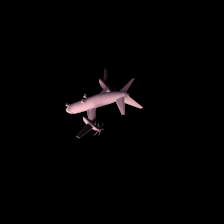

In [37]:
Image.open("%s/02691156/images/%s.png"%(data_folder, chosen_images[13]))

In [17]:
cho
sen_images

['02691156_7f837b389e885af471b4c018296f73c7_K3VbH7TtCZdqI1qc',
 '02691156_131db4a650873babad3ab188d086d4db_f5XtBtun8FkIydlU',
 '02691156_131db4a650873babad3ab188d086d4db_gGZ6neLRZ3jaP4gw',
 '02691156_7dfaa526d4b432e867c54439d6177032_3QAcP2Ew7AY8y4Kh',
 '02691156_1d6afc44b053ab07941d71475449eb25_Vm8PeJUexIU8PwJa',
 '02691156_7f837b389e885af471b4c018296f73c7_zWd8C1999iGY3ARP',
 '02691156_67da7044f5bee4f65c6d168c6e7f59dc_UBBRaFxnyueg914L',
 '02691156_67da7044f5bee4f65c6d168c6e7f59dc_57lWe6s8p1OdQh9F',
 '02691156_24fbe7a49fd786c5fb5c1b0f759e2bc1_9BOWLihfJq2tWWTV',
 '02691156_1d6afc44b053ab07941d71475449eb25_pBLmXnp7JxIrZJhC',
 '02691156_97bd6259fd4dd69a90baeef8ba5b93e5_o5jDHVr2n4TeqlLR',
 '02691156_7dfaa526d4b432e867c54439d6177032_xvnRtdob1vTxPEhf',
 '02691156_1d6afc44b053ab07941d71475449eb25_HzmrcurPuJUeINmc',
 '02691156_1d6afc44b053ab07941d71475449eb25_yccSUTIe7N3z9MbM',
 '02691156_1d6afc44b053ab07941d71475449eb25_aJgWwVBx8bb9rds2',
 '02691156_67da7044f5bee4f65c6d168c6e7f59dc_LYBRmoYEKLd

In [15]:
done = 0
total = 0
for chosen_image in chosen_images:
    rendered_ims, im_names, random_infos = render_shapenet_cluster(category_info, chosen_image)
    for i in range(len(rendered_ims)):
        rendered_im = rendered_ims[i]
        im_name = im_names[i]
        random_info = random_infos[i]

        RANDOMIZED_INFORMATION_CATEGORY[im_name] = random_info
        image_path = "%s/%s.png"%(images_folder, im_name)
        rendered_im.save(image_path)
        if total % 10 == 0:
            with open('%s/randomized_info_%s.p'%(category_path, category),'wb') as F:
                pickle.dump(RANDOMIZED_INFORMATION_CATEGORY, F)
        total += 1
    done += 1
    if done == 2:
        break

tensor([1.0374, 0.0702, 1.2844])
Scene construction, time: 0.42350 s
Forward pass, time: 0.94919 s
Scene construction, time: 0.40657 s
Forward pass, time: 0.92633 s
Scene construction, time: 0.40490 s
Forward pass, time: 0.92901 s
Scene construction, time: 0.40435 s
Forward pass, time: 0.92270 s
Scene construction, time: 0.40439 s
Forward pass, time: 0.91582 s


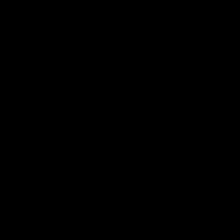

In [16]:
rendered_ims[0]